## Data Visualization Project Information 

In my independent project, I utilized various Scikit-Learn models to demonstrate my understanding of data visualization and how to extract insights from model results.

# Apple (AAPL) Stock Price Prediction Using Past 30 Days Data

## 1: Using Support Vector Regression

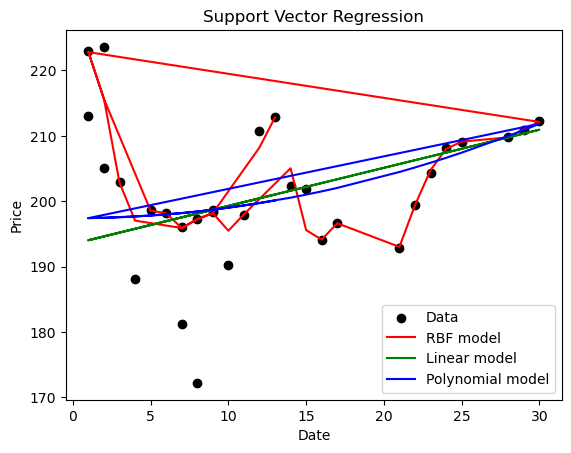

(211.03339704121203, 210.34769752904904, 210.88085153161046)
<function predict_prices at 0x00000285EBF7FE20>


In [ ]:
import csv
import numpy as np
from sklearn.svm import SVR
import matplotlib.pyplot as plt

dates = []
prices = []

def get_data(filename):
    with open(filename, 'r') as csvfile:
        csvFileReader = csv.reader(csvfile)
        next(csvFileReader)  # Skip header
        for row in csvFileReader:
            # Assuming the first column is a date in 'YYYY-MM-DD' format
            # Use the day as the feature for regression
            try:
                day = int(row[0].split('-')[2])
                price = float(row[1])
                dates.append(day)
                prices.append(price)
            except (IndexError, ValueError):
                # Skip rows with invalid data
                continue
    return

def predict_prices(dates, prices, x):
    dates = np.reshape(dates, (len(dates), 1))
    x = np.array(x).reshape(-1, 1)  # Ensure x is 2D

    svr_lin = SVR(kernel='linear', C=1e3)
    svr_poly = SVR(kernel='poly', C=1e3, degree=2)
    svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
    svr_lin.fit(dates, prices)
    svr_poly.fit(dates, prices)
    svr_rbf.fit(dates, prices)

    plt.scatter(dates, prices, color='black', label='Data')
    plt.plot(dates, svr_rbf.predict(dates), color='red', label='RBF model')
    plt.plot(dates, svr_lin.predict(dates), color='green', label='Linear model')
    plt.plot(dates, svr_poly.predict(dates), color='blue', label='Polynomial model')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('Support Vector Regression')
    plt.legend()
    plt.show()

    return svr_rbf.predict(x)[0], svr_lin.predict(x)[0], svr_poly.predict(x)[0]

get_data('AAPL_30d.csv')

predicted_price = predict_prices(dates, prices, [29])  # Pass as list

print(predicted_price)
print(predict_prices)



## 2: Using Synthetic Data Generation

### Importing Libraries

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score,
    classification_report,
    roc_curve,
)

# Import SMOTE
!pip install imbalanced-learn
from imblearn.over_sampling import SMOTE

### Preview the Data

In [ ]:
import pandas as pd
stock_data = pd.read_csv('AAPL_30d.csv', skiprows=2)  # skip the first two header rows

print("\nShape of the dataset (rows, columns):", stock_data.shape)
print("\nFirst 5 rows of the dataset:")
#Clean the data to present a more readable format
df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
print(df.head())



Shape of the dataset (rows, columns): (32, 6)

First 5 rows of the dataset:
         Date       Close        High         Low        Open     Volume
0  2025-04-01  222.897705  223.387054  218.613315  219.522127   36412700
1  2025-04-02  223.596786  224.895087  220.730550  221.030160   35905900
2  2025-04-03  202.923904  207.218276  200.986443  205.270818  103419000
3  2025-04-04  188.133301  199.618240  187.094654  193.636079  125910900
4  2025-04-07  181.222366  193.895735  174.391312  176.967935  160466300
